## Import Library

In [ ]:
# Library umum digunakan
import os, shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
from tqdm.notebook import tqdm as tq
import seaborn as sns

In [ ]:
# Libaries untuk pemrosesan gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import rotate, resize, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, Layer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import keras_cv

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
print(tf.__version__)

2.18.0


## Data Loading

In [ ]:
!mkdir -p ~/.kaggle
!cp ../input/dataset-api/kaggle_2.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d samithsachidanandan/human-face-emotions

Dataset URL: https://www.kaggle.com/datasets/samithsachidanandan/human-face-emotions
License(s): apache-2.0
human-face-emotions.zip: Skipping, found more recently modified local copy (use --force to force download)


## Data Preparation

In [ ]:
# Data Preparation for Deep Learning Manual
path = './Data'
batch_size = 256

train_ds = image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(128, 128),
    batch_size=batch_size,
    color_mode='grayscale'
)

val_ds = image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(128, 128),
    batch_size=batch_size,
    color_mode='grayscale'
)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

train_batches = tf.data.experimental.cardinality(train_ds)
val_batches = tf.data.experimental.cardinality(val_ds)
test_batches = tf.data.experimental.cardinality(test_ds)

Found 59099 files belonging to 5 classes.
Using 47280 files for training.
Found 59099 files belonging to 5 classes.
Using 11819 files for validation.


In [ ]:
train_batch = train_batches.numpy()
val_batch = val_batches.numpy()
test_batch = test_batches.numpy()

print(f'Jumlah Data Train: {train_batch * batch_size}')
print(f'Jumlah Data Validation: {val_batch * batch_size}')
print(f'Jumlah Data Train: {test_batch * batch_size}')

Jumlah Data Train: 47360
Jumlah Data Validation: 6144
Jumlah Data Train: 5888


In [ ]:
# Data Preparation for Transfer Learning
CLASS_NAMES = ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
img_size_rgb = (224, 224)

def preprocess_rgb(image, label):
  return preprocess_input(image), label

train_ds_rgb = image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=img_size_rgb,
    batch_size=batch_size,
    class_names=CLASS_NAMES,
    color_mode='rgb'
    )

val_ds_rgb = image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size_rgb,
    batch_size=batch_size,
    class_names=CLASS_NAMES,
    color_mode='rgb'
)

train_ds_rgb = train_ds_rgb.map(preprocess_rgb).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_rgb = val_ds_rgb.map(preprocess_rgb).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds_rgb_batches = tf.data.experimental.cardinality(val_ds_rgb)
test_ds_rgb = val_ds_rgb.take(val_ds_rgb_batches // 2)
val_ds_rgb = val_ds_rgb.skip(val_ds_rgb_batches // 2)

Found 59099 files belonging to 5 classes.
Using 47280 files for training.
Found 59099 files belonging to 5 classes.
Using 11819 files for validation.


## Dataset Checking

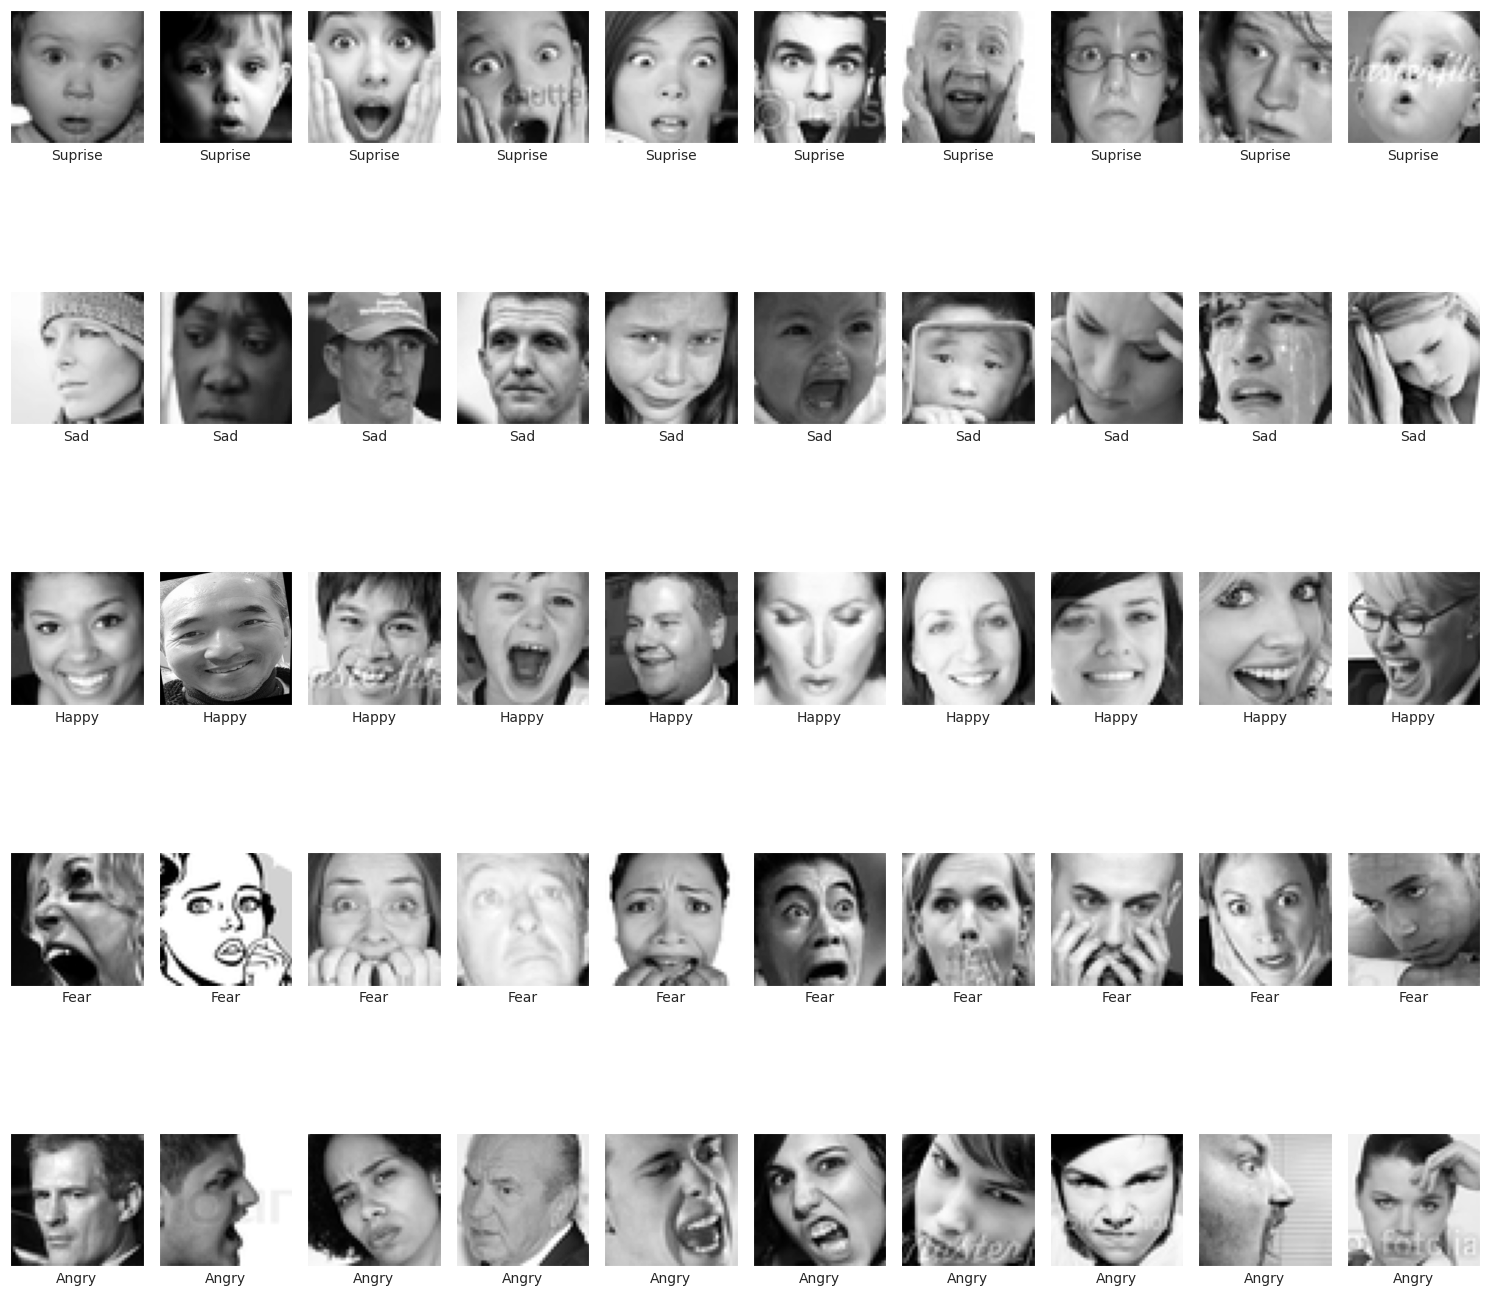

In [ ]:
lung_image = {}

for i in os.listdir(path):
  lung_image[i] = os.listdir(os.path.join(path, i))

fig, axs = plt.subplots(len(lung_image.keys()), 10, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
  images = np.random.choice(lung_image[class_name], 10, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path, class_name, image_name)
    img = Image.open(img_path).convert('L')
    axs[i, j].imshow(img, cmap='gray')
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

plt.tight_layout()
plt.show()

## Plot Distribusi

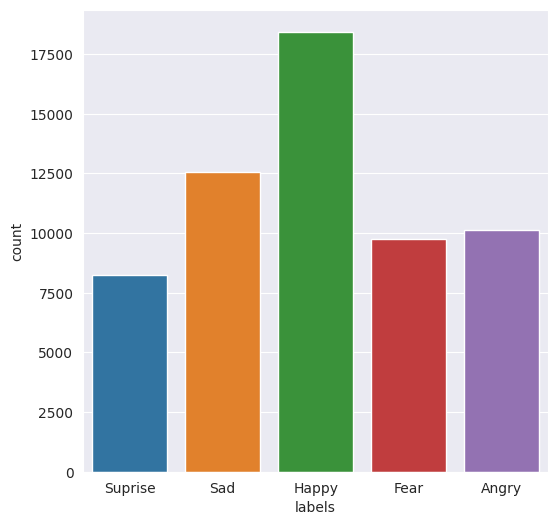

In [ ]:
file_name = []
labels = []
full_path = []

root_path = '/kaggle/working/Data'

for path, subdirs, files in os.walk(root_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({'path': full_path, 'file_name': file_name, 'labels': labels})

label = distribution_train['labels']
plt.figure(figsize=(6, 6))
sns.set_style('darkgrid')
sns.countplot(x=label)
plt.show()

## Modelling

In [ ]:
model = Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)),

    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2),
    tf.keras.layers.Dropout(0.1),

    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2),

    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(4),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,107,525 (4.22 MB)

 Trainable params: 1,106,693 (4.22 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=8,
                   verbose=1,
                   restore_best_weights=True)

rp = ReduceLROnPlateau(monitor='val_accuracy',
                       patience=3,
                       verbose=1,
                       factor=0.1)

mc_base = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_base.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

mc_base_aug = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_base_aug.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

mc_tl = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_transfer_learning.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

mc_tl_aug = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_transfer_learning_aug.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[es, rp, mc_base])

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.3720 - loss: 1.6545
Epoch 1: val_accuracy improved from -inf to 0.49941, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - accuracy: 0.3723 - loss: 1.6534 - val_accuracy: 0.4994 - val_loss: 1.1893 - learning_rate: 0.0010
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5252 - loss: 1.1747
Epoch 2: val_accuracy improved from 0.49941 to 0.53195, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.5253 - loss: 1.1745 - val_accuracy: 0.5320 - val_loss: 1.1715 - learning_rate: 0.0010
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5758 - loss: 1.0534
Epoch 3: val_accuracy improved from 0.53195 to 0.60260, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.5759 - loss: 1.0533 - val_accuracy: 0.6026 - val_loss: 0.9810 - learning_rate: 0.0010
Epoch 4/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6109 - loss: 0.9817
Epoch 4: val_accuracy improved from 0.60260 to 0.62704, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - accuracy: 0.6110 - loss: 0.9815 - val_accuracy: 0.6270 - val_loss: 0.9323 - learning_rate: 0.0010
Epoch 5/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6363 - loss: 0.9246
Epoch 5: val_accuracy improved from 0.62704 to 0.64761, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.6363 - loss: 0.9245 - val_accuracy: 0.6476 - val_loss: 0.8981 - learning_rate: 0.0010
Epoch 6/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6581 - loss: 0.8720
Epoch 6: val_accuracy did not improve from 0.64761
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.6581 - loss: 0.8719 - val_accuracy: 0.6468 - val_loss: 0.9039 - learning_rate: 0.0010
Epoch 7/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6788 - loss: 0.8246
Epoch 7: val_accuracy improved from 0.64761 to 0.68488, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.6788 - loss: 0.8244 - val_accuracy: 0.6849 - val_loss: 0.8143 - learning_rate: 0.0010
Epoch 8/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7008 - loss: 0.7748
Epoch 8: val_accuracy improved from 0.68488 to 0.70932, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.7008 - loss: 0.7747 - val_accuracy: 0.7093 - val_loss: 0.7634 - learning_rate: 0.0010
Epoch 9/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7176 - loss: 0.7327
Epoch 9: val_accuracy improved from 0.70932 to 0.71927, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.7176 - loss: 0.7327 - val_accuracy: 0.7193 - val_loss: 0.7311 - learning_rate: 0.0010
Epoch 10/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7380 - loss: 0.6821
Epoch 10: val_accuracy improved from 0.71927 to 0.74709, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.7380 - loss: 0.6819 - val_accuracy: 0.7471 - val_loss: 0.6731 - learning_rate: 0.0010
Epoch 11/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7562 - loss: 0.6366
Epoch 11: val_accuracy improved from 0.74709 to 0.75974, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.7563 - loss: 0.6364 - val_accuracy: 0.7597 - val_loss: 0.6513 - learning_rate: 0.0010
Epoch 12/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7735 - loss: 0.6012
Epoch 12: val_accuracy improved from 0.75974 to 0.76429, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.7736 - loss: 0.6010 - val_accuracy: 0.7643 - val_loss: 0.6324 - learning_rate: 0.0010
Epoch 13/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7904 - loss: 0.5591
Epoch 13: val_accuracy improved from 0.76429 to 0.80155, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.7905 - loss: 0.5590 - val_accuracy: 0.8016 - val_loss: 0.5663 - learning_rate: 0.0010
Epoch 14/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8076 - loss: 0.5124
Epoch 14: val_accuracy improved from 0.80155 to 0.80357, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.8077 - loss: 0.5123 - val_accuracy: 0.8036 - val_loss: 0.5531 - learning_rate: 0.0010
Epoch 15/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8177 - loss: 0.4885
Epoch 15: val_accuracy improved from 0.80357 to 0.81959, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.8177 - loss: 0.4883 - val_accuracy: 0.8196 - val_loss: 0.5216 - learning_rate: 0.0010
Epoch 16/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8322 - loss: 0.4598
Epoch 16: val_accuracy improved from 0.81959 to 0.84809, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.8323 - loss: 0.4596 - val_accuracy: 0.8481 - val_loss: 0.4685 - learning_rate: 0.0010
Epoch 17/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8460 - loss: 0.4202
Epoch 17: val_accuracy did not improve from 0.84809
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.8461 - loss: 0.4201 - val_accuracy: 0.8393 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 18/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8568 - loss: 0.3956
Epoch 18: val_accuracy improved from 0.84809 to 0.85399, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.8568 - loss: 0.3956 - val_accuracy: 0.8540 - val_loss: 0.4334 - learning_rate: 0.0010
Epoch 19/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8670 - loss: 0.3654
Epoch 19: val_accuracy improved from 0.85399 to 0.85584, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.8670 - loss: 0.3654 - val_accuracy: 0.8558 - val_loss: 0.4261 - learning_rate: 0.0010
Epoch 20/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8701 - loss: 0.3550
Epoch 20: val_accuracy improved from 0.85584 to 0.88366, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.8701 - loss: 0.3549 - val_accuracy: 0.8837 - val_loss: 0.3884 - learning_rate: 0.0010
Epoch 21/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8786 - loss: 0.3355
Epoch 21: val_accuracy improved from 0.88366 to 0.88923, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.8786 - loss: 0.3355 - val_accuracy: 0.8892 - val_loss: 0.3665 - learning_rate: 0.0010
Epoch 22/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8859 - loss: 0.3152
Epoch 22: val_accuracy did not improve from 0.88923
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.8859 - loss: 0.3152 - val_accuracy: 0.8872 - val_loss: 0.3687 - learning_rate: 0.0010
Epoch 23/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8888 - loss: 0.3045
Epoch 23: val_accuracy improved from 0.88923 to 0.90069, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.8889 - loss: 0.3044 - val_accuracy: 0.9007 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 24/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8960 - loss: 0.2903
Epoch 24: val_accuracy improved from 0.90069 to 0.90406, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.8960 - loss: 0.2902 - val_accuracy: 0.9041 - val_loss: 0.3369 - learning_rate: 0.0010
Epoch 25/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8975 - loss: 0.2806
Epoch 25: val_accuracy did not improve from 0.90406
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.8975 - loss: 0.2805 - val_accuracy: 0.8960 - val_loss: 0.3375 - learning_rate: 0.0010
Epoch 26/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9068 - loss: 0.2615
Epoch 26: val_accuracy improved from 0.90406 to 0.90423, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.9068 - loss: 0.2614 - val_accuracy: 0.9042 - val_loss: 0.3341 - learning_rate: 0.0010
Epoch 27/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9108 - loss: 0.2505
Epoch 27: val_accuracy improved from 0.90423 to 0.91418, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.9108 - loss: 0.2505 - val_accuracy: 0.9142 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 28/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9118 - loss: 0.2456
Epoch 28: val_accuracy improved from 0.91418 to 0.91958, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.9118 - loss: 0.2455 - val_accuracy: 0.9196 - val_loss: 0.3034 - learning_rate: 0.0010
Epoch 29/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9138 - loss: 0.2413
Epoch 29: val_accuracy improved from 0.91958 to 0.92143, saving model to model_base.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - accuracy: 0.9138 - loss: 0.2412 - val_accuracy: 0.9214 - val_loss: 0.2886 - learning_rate: 0.0010
Epoch 30/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9185 - loss: 0.2295
Epoch 30: val_accuracy did not improve from 0.92143
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.9185 - loss: 0.2294 - val_accuracy: 0.9170 - val_loss: 0.3101 - learning_rate: 0.0010
Epoch 31/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9214 - loss: 0.2214
Epoch 31: val_accuracy did not improve from 0.92143
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.9214 - loss: 0.2213 - val_accuracy: 0.9182 - val_loss: 0.3003 - learning_rate: 0.0010
Epoch 32/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9236 - loss: 0.2168
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 32: val_accuracy did not improve from 0.92143
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.9236 - l

185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.9312 - loss: 0.1969 - val_accuracy: 0.9283 - val_loss: 0.2630 - learning_rate: 1.0000e-04
Epoch 34/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9348 - loss: 0.1835
Epoch 34: val_accuracy did not improve from 0.92834
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.9348 - loss: 0.1835 - val_accuracy: 0.9265 - val_loss: 0.2680 - learning_rate: 1.0000e-04
Epoch 35/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9410 - loss: 0.1729
Epoch 35: val_accuracy did not improve from 0.92834
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.9410 - loss: 0.1728 - val_accuracy: 0.9245 - val_loss: 0.2752 - learning_rate: 1.0000e-04
Epoch 36/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9425 - loss: 0.1689
Epoch 36: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 36: val_accuracy did not improve from 0.92834
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy

In [ ]:
model_base_path = 'model_base.h5'
load_model_base = tf.keras.models.load_model(model_base_path)
load_model_base.evaluate(test_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9268 - loss: 0.2531


[0.2679491341114044, 0.92408287525177]

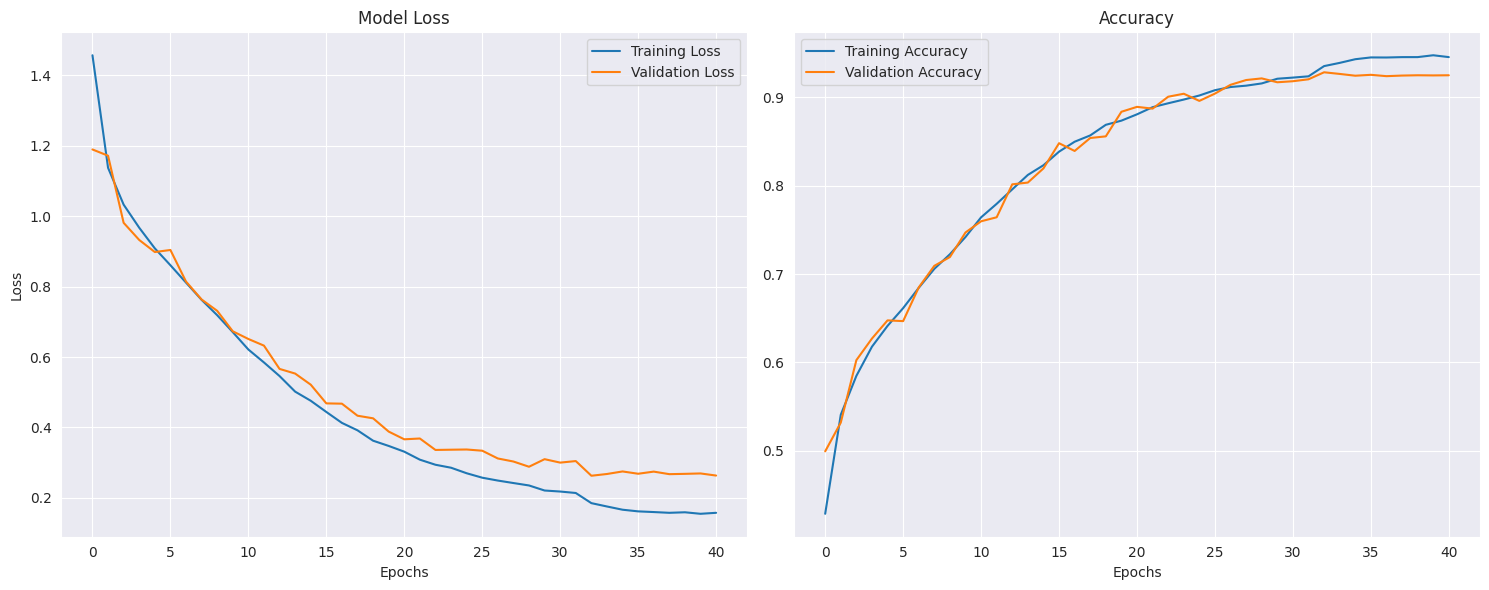

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# -----Loss-----
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ----Accuracy----
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Transfer Learning Model

In [ ]:
base_model_tl = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model_tl.trainable = False

model_tl = Sequential([
    base_model_tl,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_tl.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,088,117 (4.15 MB)

 Trainable params: 148,997 (582.02 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
model_tl.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_tl = model_tl.fit(train_ds_rgb, validation_data=val_ds_rgb, batch_size=batch_size, epochs=50, callbacks=[es, rp, mc_tl])

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4108 - loss: 1.4196
Epoch 1: val_accuracy improved from -inf to 0.54696, saving model to model_transfer_learning.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 69s 300ms/step - accuracy: 0.4112 - loss: 1.4190 - val_accuracy: 0.5470 - val_loss: 1.1456 - learning_rate: 0.0010
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5388 - loss: 1.1495
Epoch 2: val_accuracy improved from 0.54696 to 0.57258, saving model to model_transfer_learning.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - accuracy: 0.5388 - loss: 1.1495 - val_accuracy: 0.5726 - val_loss: 1.0768 - learning_rate: 0.0010
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5684 - loss: 1.0857
Epoch 3: val_accuracy improved from 0.57258 to 0.58860, saving model to model_transfer_learning.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.5685 - loss: 1.0857 - val_accuracy: 0.5886 - val_loss: 1.0333 - learning_rate: 0.0010
E

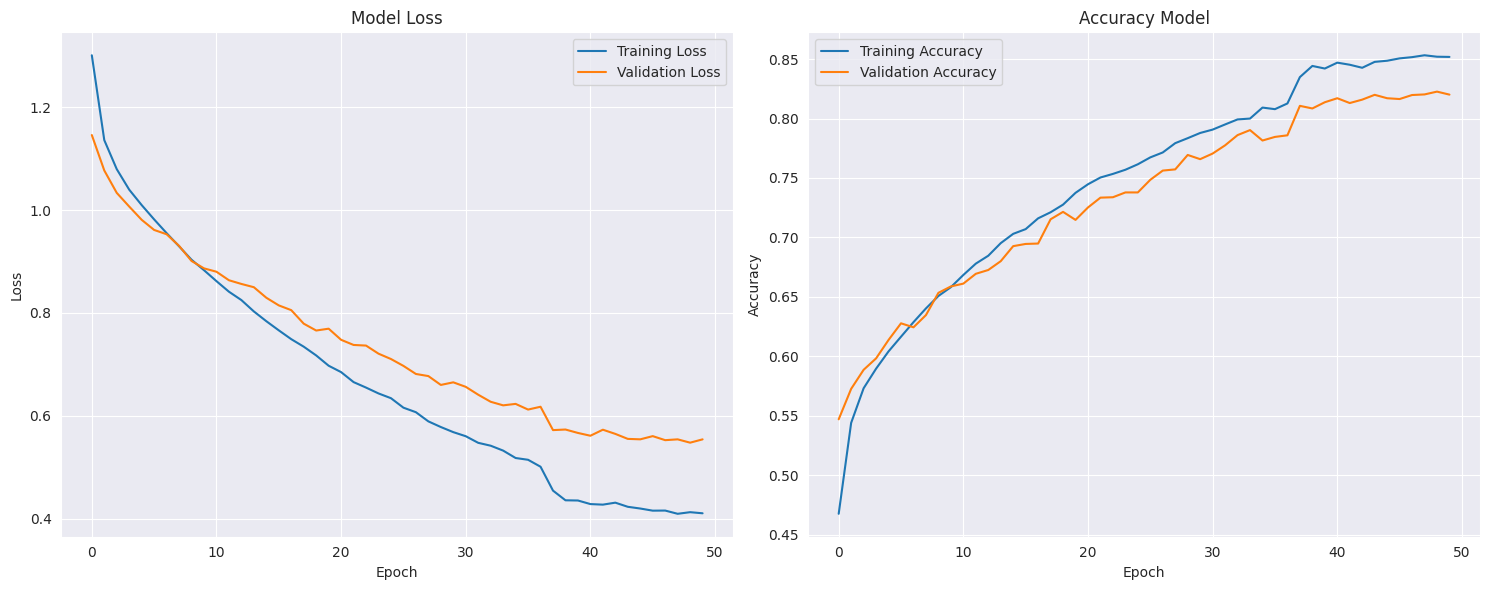

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(history_tl.history['loss'], label='Training Loss')
ax1.plot(history_tl.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history_tl.history['accuracy'], label='Training Accuracy')
ax2.plot(history_tl.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy Model')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
model_tl_path = 'model_transfer_learning.keras'
load_model_tl = tf.keras.models.load_model(model_tl_path)
load_model_tl.evaluate(test_ds_rgb)

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.8127 - loss: 0.5555


[0.5513927936553955, 0.815557062625885]

## Export Best Model

In [ ]:
os.makedirs('saved_model', exist_ok=True)
export_dir = 'saved_model/'

tf.saved_model.save(load_model_base, export_dir)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


## Convert Model to TensorflowLite

In [ ]:
os.makedirs('tflite', exist_ok=True)
PATH_TO_ORIGINAL_MODEL = 'model_base.h5'


model = tf.keras.models.load_model(PATH_TO_ORIGINAL_MODEL)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

new_tflite_path = 'tflite/best_model.tflite'
with open(new_tflite_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpv9iswhav/assets


INFO:tensorflow:Assets written to: /tmp/tmpv9iswhav/assets


Saved artifact at '/tmp/tmpv9iswhav'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139925802390288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139925802385680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139925802389520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139925802387024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139925802387408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139925802385488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139925802386256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139925802388368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139925804105360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139925804104208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1399258023877

W0000 00:00:1763098344.403193      48 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1763098344.403228      48 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1763098344.418030      48 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


## Convert Model to TensorflowJS

In [1]:
!tensorflowjs_converter --input_format=keras model_base.h5 tfjs_model

2025-11-14 05:37:40.481470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763098660.502415     650 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763098660.509240     650 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763098660.524506     650 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763098660.524532     650 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763098660.524537     650 computation_placer.cc:177] computation placer alr

## Inference Model from Tenforflow-Lite

Menguji gambar dari kelas: 'Angry'


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


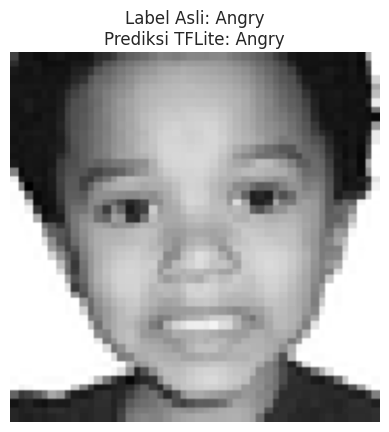

In [ ]:
tflite_path = 'tflite/best_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

path = './Data'
random_label = random.choice(CLASS_NAMES)
image_file = random.choice(os.listdir(os.path.join(path, random_label)))
image_path = os.path.join(path, random_label, image_file)

print(f"Menguji gambar dari kelas: '{random_label}'")

img_height = input_details[0]['shape'][1]
img_width = input_details[0]['shape'][2]

img = image.load_img(image_path, target_size=(img_height, img_width), color_mode="grayscale")
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], img_batch)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_index = np.argmax(output_data[0])
predicted_label = CLASS_NAMES[predicted_index]

plt.imshow(img, cmap='gray')
plt.title(f"Label Asli: {random_label}\nPrediksi TFLite: {predicted_label}")
plt.axis('off')
plt.show()